In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchinfo import summary

from torch import nn
from torchvision import transforms

try:
    from going_modular.going_modular import data_setup, engine
except:
    print(f'[INFO] No going_modular founded, downloading...')
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !move pytorch-deep-learning/going_modular .
    !rmdir pytorch-deep-learning
    
    from going_modular.going_modular import data_setup, engine

In [3]:
import requests
from pathlib import Path

try:
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print(f"[INFO] No helper_functions founded, downloading...")
    with open('helper_functions.py', "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
        f.write(request.content)
        
    from helper_functions import download_data, set_seeds, plot_loss_curves
    

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [6]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

In [7]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
    param.requires_grad = False

In [8]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3)
)

effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [10]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [12]:
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [13]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [14]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [15]:
import torch
torch.cuda.empty_cache()

In [16]:
!nvidia-smi

Tue Oct 22 20:32:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   36C    P3             12W /   35W |     155MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5771 | test_loss: 0.7385 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7111 | train_acc: 0.8521 | test_loss: 0.5865 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5859 | train_acc: 0.8979 | test_loss: 0.4891 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4499 | train_acc: 0.9104 | test_loss: 0.4341 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4278 | train_acc: 0.9083 | test_loss: 0.3921 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4405 | train_acc: 0.8833 | test_loss: 0.3524 | test_acc: 0.9597
Epoch: 7 | train_loss: 0.4263 | train_acc: 0.8812 | test_loss: 0.3269 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3836 | train_acc: 0.9083 | test_loss: 0.3478 | test_acc: 0.9352
Epoch: 9 | train_loss: 0.3739 | train_acc: 0.8833 | test_loss: 0.3146 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3668 | train_acc: 0.8667 | test_loss: 0.2817 | test_acc: 0.9688


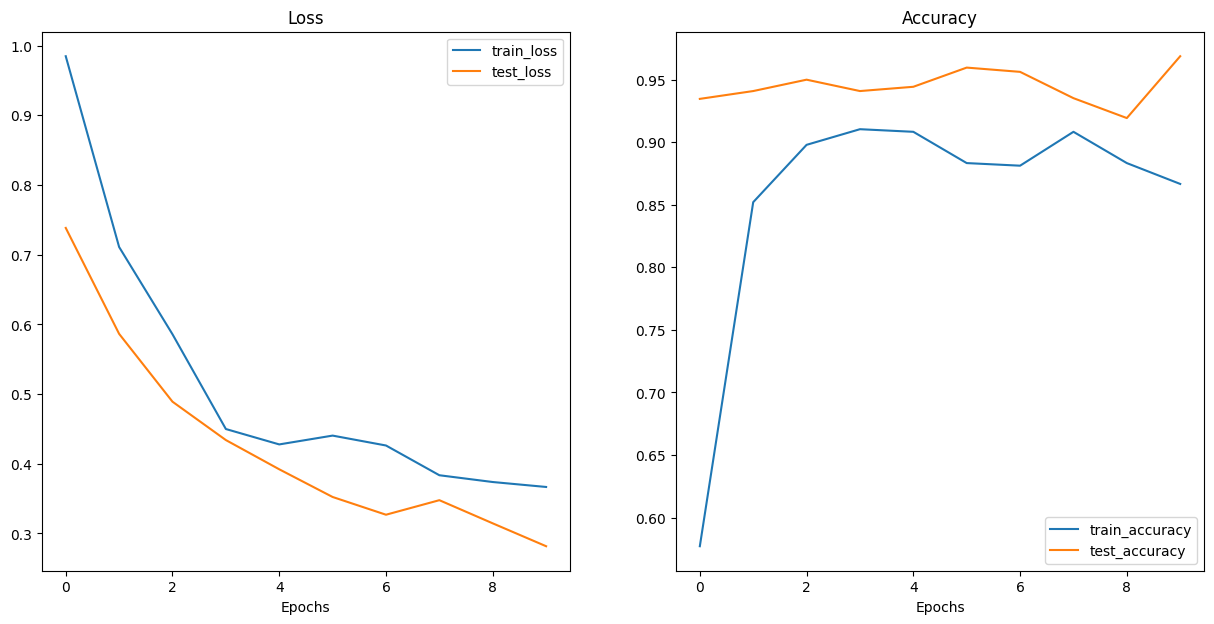

In [18]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [19]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [20]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [21]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28173364102840426,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [23]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [26]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [27]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

In [28]:
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\Trung Minh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\activation.py:1230: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [29]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [30]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=5,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784


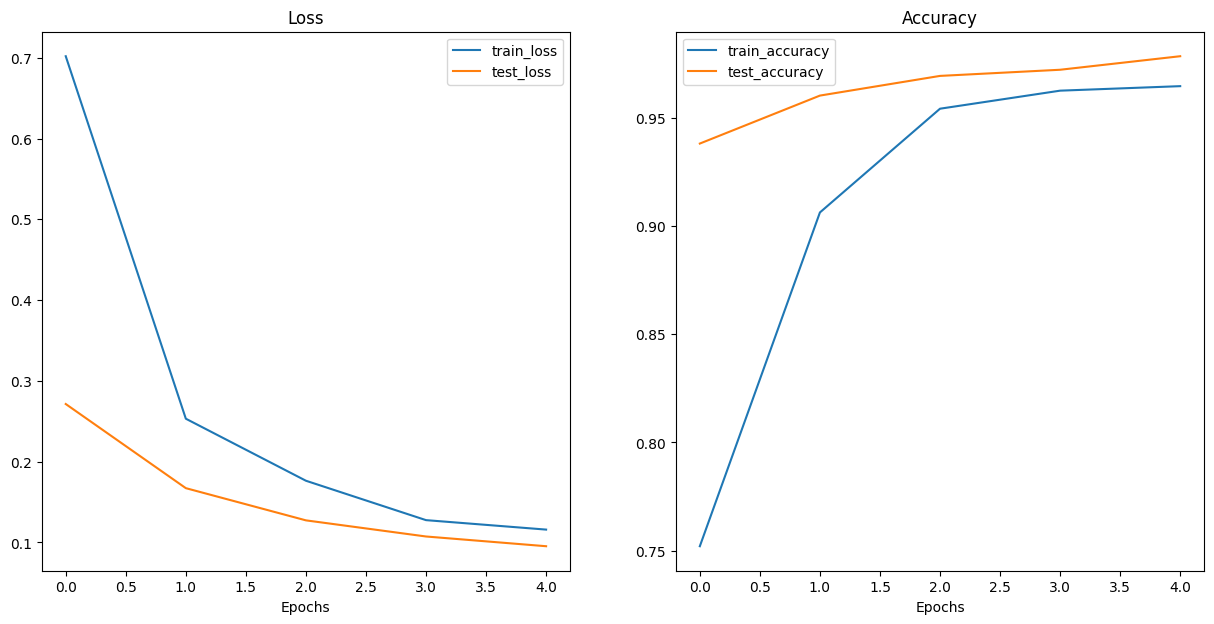

In [31]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [32]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [33]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [34]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [35]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.09531366322189569,
 'test_acc': 0.978409090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [39]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

In [44]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths, model, transform, class_names,device=device):
    pred_list = []
    
    for path in tqdm(paths):
        pred_dict = {}
        
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        start_time = timer()
        
        img = Image.open(path)
        
        transformed_image = transform(img).unsqueeze(0).to(device)
        
        model.to(device)
        model.eval()
        
        with torch.inference_mode():
            pred_logits = model(transformed_image)
            pred_prob = torch.softmax(pred_logits, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label]
            
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)
        
        pred_dict["correct"] = class_name == pred_class
        pred_list.append(pred_dict)
        
    return pred_list

In [45]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

  0%|          | 0/150 [00:00<?, ?it/s]

In [46]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'time_for_pred': 0.1879,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'time_for_pred': 0.0861,
  'correct': True}]

In [60]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.1879,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.0861,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.0776,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.0802,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.0731,True


In [48]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     145
False      5
Name: count, dtype: int64

In [49]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0666 seconds


In [65]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats.pop("time_for_pred_cpu")
effnetb2_stats

{'test_loss': 0.28173364102840426,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': np.float64(0.0666)}

In [50]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [51]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'time_for_pred': 1.4815,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'time_for_pred': 0.3436,
  'correct': True}]

In [52]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,1.4815,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.3436,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.3215,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.2715,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.2080,True


In [53]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     147
False      3
Name: count, dtype: int64

In [54]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.2339 seconds


In [55]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.09531366322189569,
 'test_acc': 0.978409090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': np.float64(0.2339)}

In [66]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281734,96.88,7705221,29,0.0666,EffNetB2
1,0.095314,97.84,85800963,327,0.2339,ViT


In [67]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.338311,1.009909,11.135432,11.275862,3.512012


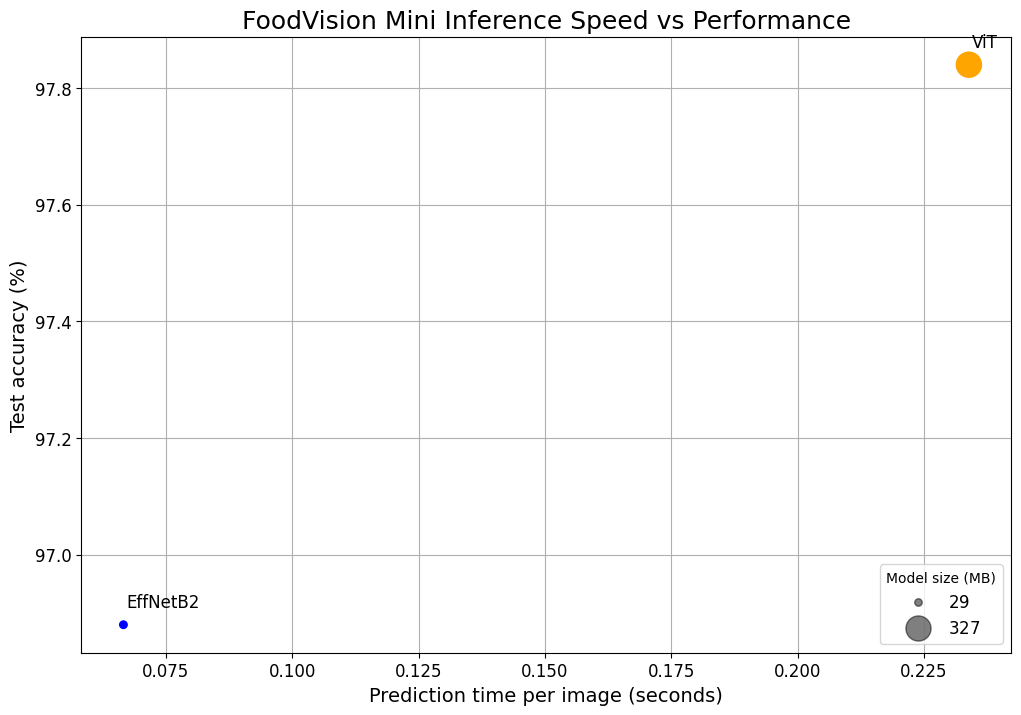

In [72]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
import os
os.makedirs("images/")
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

In [73]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

Gradio version: 5.3.0


In [74]:
# Put EffNetB2 on CPU
effnetb2.to("cpu") 

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [75]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [76]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\pizza\2901001.jpg

Prediction label and probability dictionary: 
{'pizza': 0.7387545108795166, 'steak': 0.02247132547199726, 'sushi': 0.23877421021461487}
Prediction time: 0.11402 seconds


In [77]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\steak\\2246332.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\2743100.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\1203702.jpg']]

In [78]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://4bac9c5973db6f1286.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "c:\Users\Trung Minh\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Trung Minh\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Trung Minh\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 2018, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Trung Minh\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1567, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\T

In [79]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
# If the file doesn't exist, create it anyway
foodvision_mini_demo_path.mkdir(parents=True, 
                                exist_ok=True)
    
# Check what's in the folder
!ls demos/foodvision_mini/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [80]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data\pizza_steak_sushi_20_percent\test\sushi\592799.jpg to demos\foodvision_mini\examples\592799.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\steak\3622237.jpg to demos\foodvision_mini\examples\3622237.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\pizza\2582289.jpg to demos\foodvision_mini\examples\2582289.jpg


In [81]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

In [82]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model 
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path, 
                dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos\foodvision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


In [83]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_mini/model.py


In [84]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [85]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


In [89]:
list_p = list(Path("demos/foodvision_mini").glob("*"))
list_p

[WindowsPath('demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth'),
 WindowsPath('demos/foodvision_mini/app.py'),
 WindowsPath('demos/foodvision_mini/examples'),
 WindowsPath('demos/foodvision_mini/model.py'),
 WindowsPath('demos/foodvision_mini/requirements.txt')]

In [92]:
!python demos/foodvision_mini/app.py

c:\Users\Trung Minh\My Projects\Practice Pytorch\09_PyTorch_Model_Deployment\demos\foodvision_mini\app.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(
Trace